In this notebook, we compare the indicator configuration calculation results with the scale of the target error bars of the target QoI.
Things we compare:
* Eigenvalues of the configurational FIM
* Parameter distributions
* Resulting uncertainty of the target QoI

In [1]:
from pathlib import Path
import pickle

import numpy as np
import matplotlib.pyplot as plt
from corner import corner

WORK_DIR = Path().absolute()

%matplotlib inline
plt.style.use("default")

# Load results

In [2]:
# Main dictionary to store all results
results = {}

In [3]:
# This dictionary contains the directory information that will be used to load the
# results of the indicator configuration calculation with different scale of target
# error bars
directories = {
    10: WORK_DIR / "scale1" / "3",
    20: WORK_DIR / "scale2" / "3",
    30: WORK_DIR / "scale3" / "3",
    40: WORK_DIR / "scale4" / "3",
    50: WORK_DIR / "scale5" / "3",
}
keys = directories.keys()

In [4]:
# Load the configurational FIM
for key, path in directories.items():
    filepath = path / "linearized_uq" / "jacobian_train.npy"
    jac = np.load(filepath)
    fim = jac.T @ jac
    results.update({key: {"fim": fim}})

In [5]:
# Load MCMC parameter ensemble
for key, path in directories.items():
    filepath = path / "mcmc" / "mcmc_result.pkl"
    mcmc = pickle.load(open(filepath, "rb"))
    chain = mcmc["chain"]
    samples = chain[0, :, 20_000::200].reshape((-1, 5))
    results[key].update({"samples": samples})
nsamples = len(samples)

In [6]:
# Load predictions ensemble
dalist = np.arange(-0.5, 0.51, 0.05)
for key, path in directories.items():
    filepath = path / "mcmc" / "mcmc_target.npy"
    preds = np.load(filepath)[0].reshape((-1, 20))
    results[key].update({"predictions": preds})

# Comparison plots

In [7]:
# These colors are to color code the results from calculations using different scale
# of target error bars. Magenta correspond to results with smallest error bars.
colors = ["m", "b", "tab:green", "r", "k"]

## Compare the eigenvelues of the configurational FIM

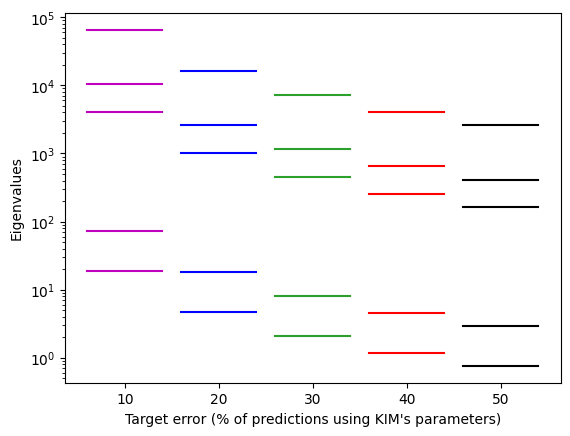

In [8]:
# Eigenvalues
plt.figure()
for ii, key in enumerate(keys):
    lams = np.linalg.eigvalsh(results[key]["fim"])
    for ll in lams:
        plt.plot([ii - 0.4, ii + 0.4], [ll, ll], c=colors[ii])
plt.yscale("log")
plt.xticks(range(5), [f"{key}" for key in keys])
plt.xlabel("Target error (% of predictions using KIM's parameters)")
plt.ylabel("Eigenvalues")
plt.show()
plt.close()

We can actually see that there is a nice pattern in the evolution of the eigenvalues of the configurational FIM as we scale up the target error bars.
To be more specific, in the indicator configuration calculation, we want
\begin{equation}
    \mathcal{I}^{\text{conf}} \geq \mathcal{I}^{\text{QoI}},
\end{equation}
where
\begin{equation}
    \mathcal{I}^{\text{conf}} = \sum_{m=1}^M w_m \mathcal{I}^{\text{conf}}_m,
\end{equation}
which is a weighted sum of the FIM of individual configuration.
Let's say that $\mathcal{I}^{\text{QoI}}_{10}$ is the target FIM that correspond to the magenta eigenvalues above.
If we increase the target error bars to $20%$, i.e., $2$ times the error bars used to get $\mathcal{I}^{\text{QoI}}_{10}$, the resulting FIM $\left(\mathcal{I}^{\text{QoI}}_{20}\right)$ would be $1/2^2~\mathcal{I}^{\text{QoI}}_{10}$.
If a set $\{w_m^*\}_{m=1}^M$ satisfies the inequality above for when we use $\mathcal{I}^{\text{QoI}}_{10}$ as the target FIM, then $\{w_m^*/2^2\}_{m=1}^M$ would satisfy the inequality when we use $\mathcal{I}^{\text{QoI}}_{20}$ as the target FIM.
In theory, as we scale the target error bars uniformly, the optimal weights will be scaled by the inverse of the squared scale.

In fact, this is exactly the behavior that we observe above.
However, this assumes that the evaluation parameters are the same in both cases.
In principle, this should be the case, since the least-squares solution won't change if we scale the residuals uniformly.

# Compare the distributions of parameters

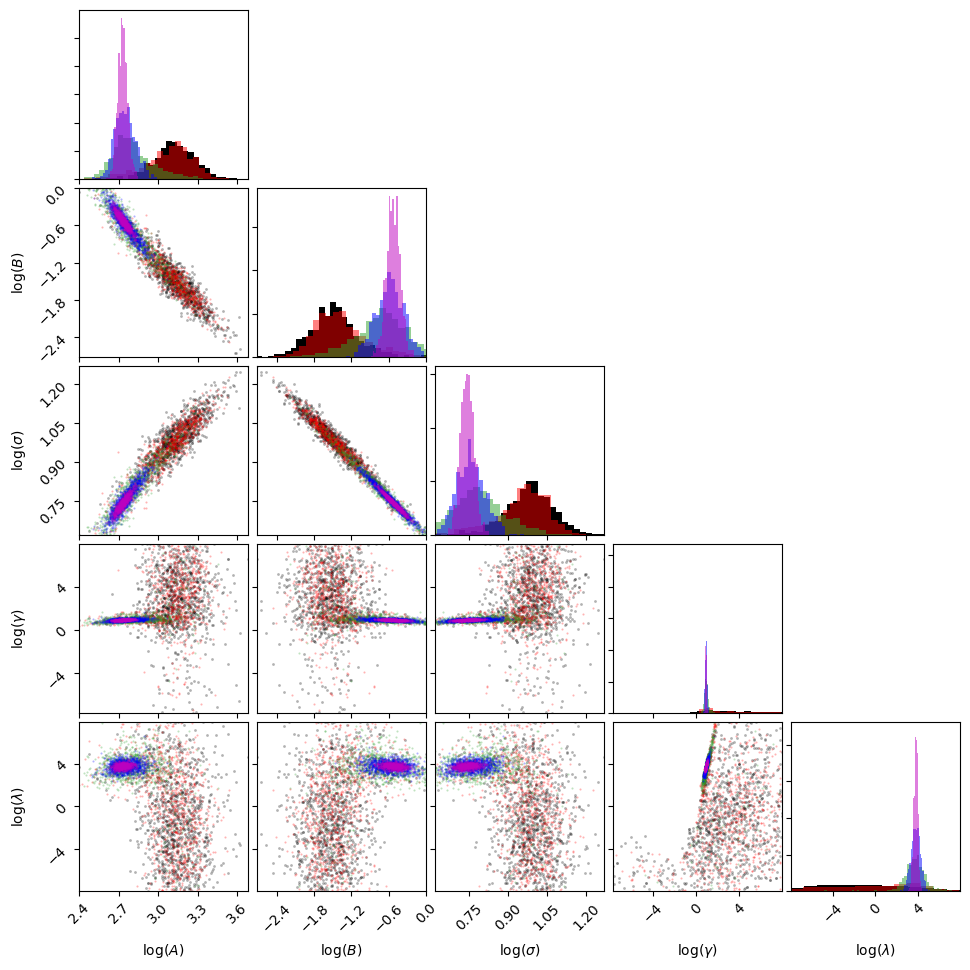

In [9]:
# MCMC samples
param_names = [
    r"$\log(A)$",
    r"$\log(B)$",
    r"$\log(\sigma)$",
    r"$\log(\gamma)$",
    r"$\log(\lambda)$",
]

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for ii, key in enumerate(np.array(list(keys))[::-1]):
    samples = results[key]["samples"]
    cc = colors[list(keys).index(key)]

    if ii == 0:
        bins = []
        max_hist = []
        for ss in samples.T:
            hist, _ = np.histogram(ss, bins="auto", density=True)
            max_hist.append(np.max(hist[0]))
            bins.append(len(hist))

        corner(
            samples,
            labels=param_names,
            bins=bins,
            fig=fig,
            hist_kwargs=dict(color=cc, density=True, histtype="stepfilled"),
            **dict(
                color=cc,
                plot_contours=False,
                plot_density=False,
                data_kwargs=dict(alpha=0.3),
            ),
        )

    else:
        for row in range(5):
            for col in range(row + 1):
                ax = axes[row, col]
                if col < row:
                    ax.plot(*(samples[:, [col, row]].T), ".", c=cc, ms=1, alpha=0.3)
                else:
                    hist, _, _ = ax.hist(
                        samples[:, col], bins="auto", density=True, color=cc, alpha=0.5
                    )
                    if np.max(hist) > max_hist[col]:
                        max_hist[col] = np.max(hist)

    # Update the axis heights on the diagonal
    for col in range(5):
        axes[col, col].set_ylim(top=max_hist[col] * 1.05)

plt.show()
plt.close()

With the relation between the eigenvalues and the scale of the target error bars, we can estimate the size of the target error bars where we start to see parameter evaporation in MCMC.
It has been shown that the eigenvalues of the FIM approximates the distance to the boundaries of the model manifold, and that parameters evaporate when the MCMC walkers approach the boundaries of the model manifold.
Using these knowledge, we can then assert that the parameters would evaporate when the smallest eigenvalue falls below $1.0$ (or close to $1.0$, due to non-linearity).

This is the behavior that we see in the corner plot above.
When the target error bars are small, the smallest eigenvalue is still significantly above $1.0$.
The distribution of the parameters are still very localized.
Then, we can observe parameter evaporation for the samples that correspond to the cases where the smallest eigenvalues of the configurational FIM approaching $1.0$.

# Compare the resulting uncertainty of the target QoI

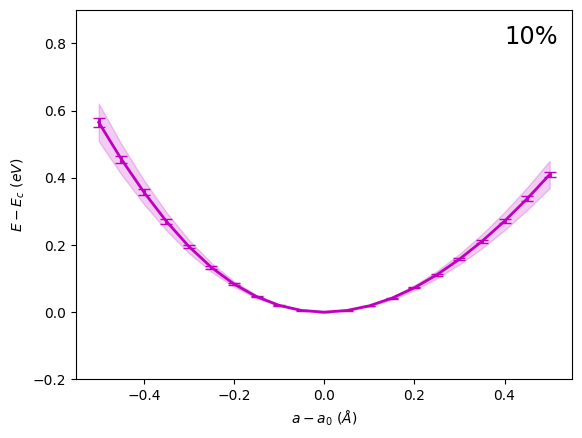

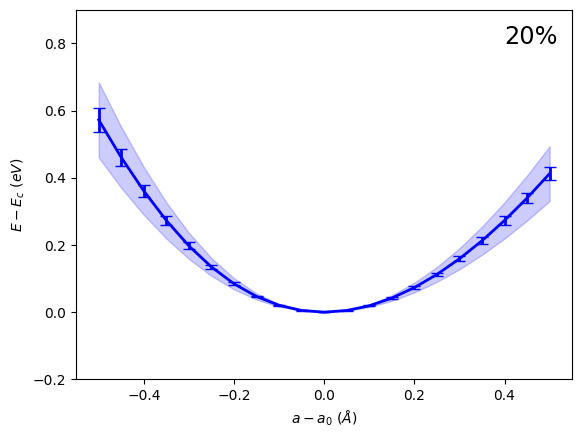

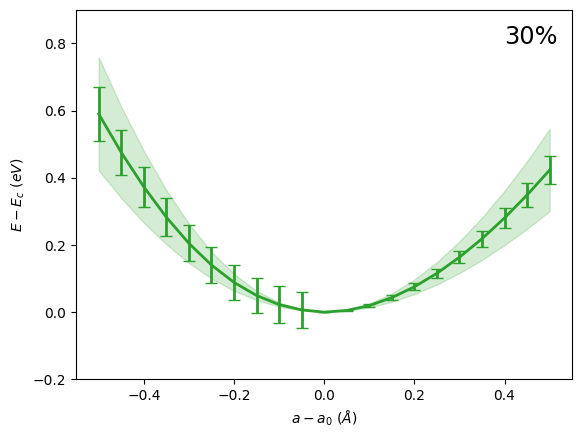

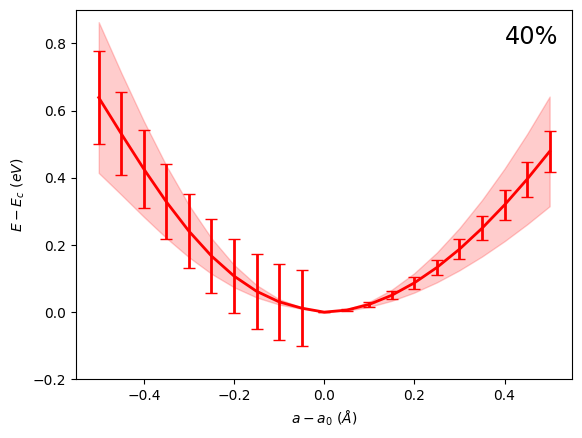

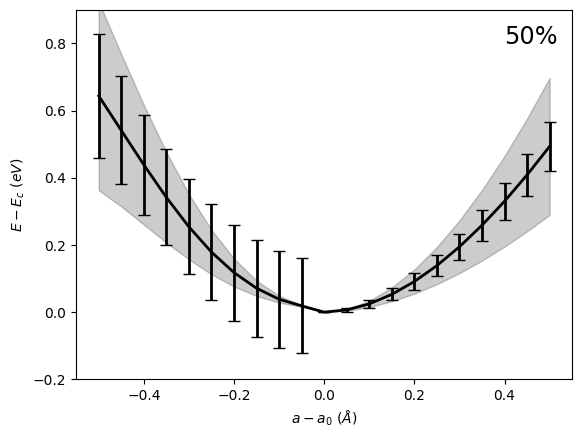

In [10]:
# Predictions
err_base = np.load(WORK_DIR.parent / "energycurve_data.npz")["error"]

for ii, key in enumerate(keys):
    plt.figure()
    err_target = err_base * 0.1 * key

    preds = results[key]["predictions"]
    mean = np.insert(np.mean(preds, axis=0), 10, 0.0)
    err = np.insert(np.std(preds, axis=0), 10, 0.0)

    plt.fill_between(
        dalist,
        mean - err_target,
        mean + err_target,
        color=colors[ii],
        alpha=0.2,
        label="target",
    )
    plt.errorbar(dalist, mean, err, c=colors[ii], lw=2, capsize=4)

    plt.ylim(-0.2, 0.9)
    plt.xlabel(r"$a-a_0~(\AA)$")
    plt.ylabel(r"$E-E_c~(eV)$")
    plt.text(0.4, 0.8, f"{key}%", fontsize="xx-large")
    # plt.legend()

plt.show()
plt.close()

As expected, the resulting uncertainty of the target QoI increases as the scale of the target QoI increases.
At small enough scale of the target error bars (e.g., $10%$ and $20%$), the propagated uncertainties of the target QoI are smaller than the target error bars.
However, at larger scale of the target error bars, for some $\Delta a$, the propagated uncertainties are actually larger than the target precision.
This happens when the MCMC samples seem to start to explore region farther away from the optimal parameters, where most likely the non-linearity of the mapping starts to dominate.
Additionally, parameter evaporation also plays a role in this behavior, as seen in even larger scale of the target error bars.
Although, interestingly that the propagated uncertainty of the target QoI are still finite even when we observe parameter evaporation.
A possible explanation is that from this calculation, the parameters that are not well constrained are not really important to making precise target QoI.